In [2]:
# Diabetes Prediction Using Clinical Data

In [3]:
# Installing important packages (mainly for Colab)
!pip install -q scikit-learn xgboost seaborn

# Importing all libraries that I’ll be using in this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn for ML models and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)

# To save trained models if needed later
import joblib

# Setting a random seed so results stay consistent each time
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [5]:
# Loading the dataset
DATA_PATH = "/content/diabetes (1).csv"

df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully with shape:", df.shape)

# Displaying first few rows to get a quick idea
df.head()


Dataset loaded successfully with shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
#Goal:
#Predict whether a patient has diabetes or not.


In [7]:
# Checking if the common target column exists
possible_targets = ['Outcome', 'Diabetes', 'diabetes', 'target', 'Class']
found_targets = [c for c in df.columns if c in possible_targets]
print("Possible target columns:", found_targets)

# Choosing the target column (most datasets use 'Outcome')
TARGET_COL = found_targets[0] if found_targets else df.columns[-1]
print("Using target column:", TARGET_COL)

# Separating features (X) and target (y)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("Number of features:", X.shape[1])
print("\nClass distribution:")
print(y.value_counts(normalize=True))


Possible target columns: ['Outcome']
Using target column: Outcome
Number of features: 8

Class distribution:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [8]:
# Checking datatypes and missing values
print("Data types:\n", X.dtypes)

print("\nMissing values in percentage:\n", X.isna().mean() * 100)

# Getting basic statistics for numeric columns
X.describe().T


Data types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

Missing values in percentage:
 Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
dtype: float64


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


Numeric columns used for plots: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


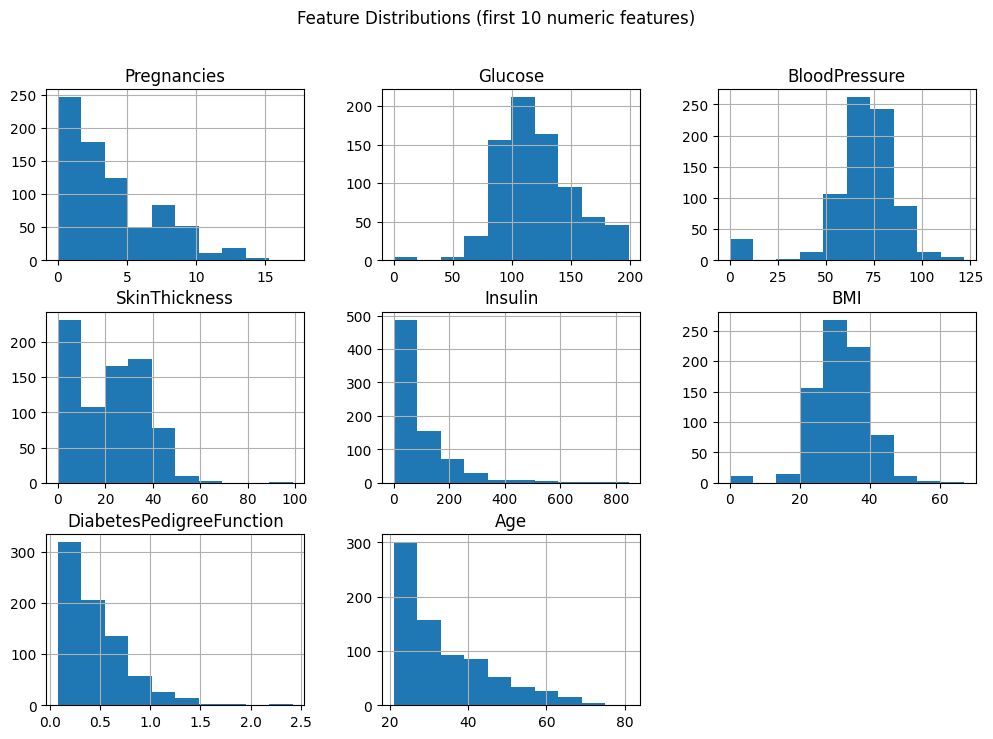

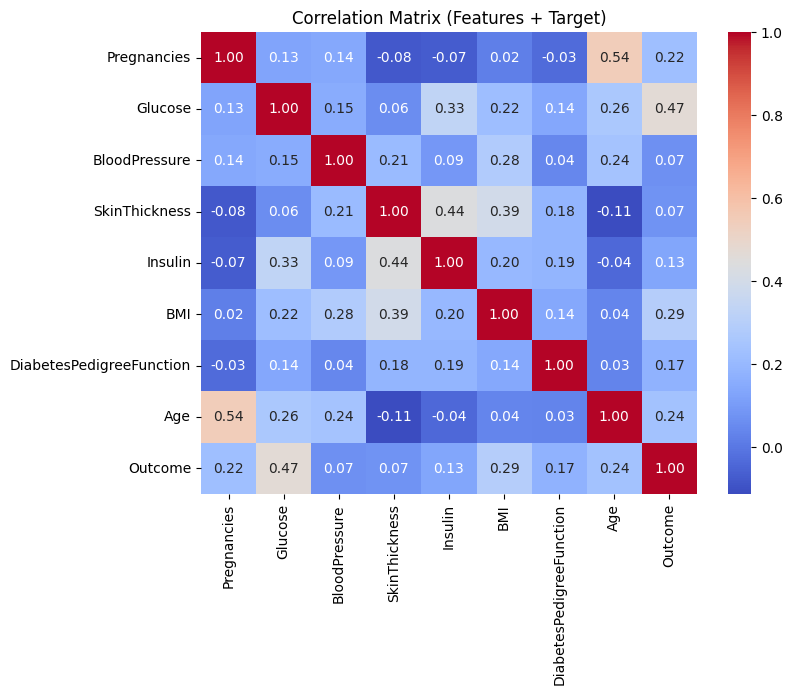

In [9]:
# Selecting up to 10 numeric columns for visualization
num_cols = X.select_dtypes(include=np.number).columns[:10]
print("Numeric columns used for plots:", num_cols.tolist())

# Plotting histograms for feature distributions
X[num_cols].hist(figsize=(12, 8))
plt.suptitle("Feature Distributions (first 10 numeric features)")
plt.show()

# Plotting correlation heatmap to check relationships
plt.figure(figsize=(8, 6))
sns.heatmap(pd.concat([X[num_cols], y], axis=1).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Features + Target)")
plt.show()


In [10]:
# Before training, I’ll handle missing data and standardize the features.
# Also, if there are more than 10 features, I’ll keep the top 10 most correlated ones with the target.

if len(num_cols) > 10:
    corr_with_target = pd.concat([X[num_cols], y], axis=1).corr()[TARGET_COL].abs().drop(TARGET_COL)
    top_features = corr_with_target.sort_values(ascending=False).head(10).index.tolist()
    print("Top 10 features selected by correlation:", top_features)
    X = X[top_features]
else:
    X = X[num_cols]

# Building a preprocessing pipeline that fills missing values and scales features
preprocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [11]:
# Splitting dataset into training and testing (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# First model: Logistic Regression (simple and interpretable)
log_reg = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

# Training baseline model
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Checking performance
print("Baseline Logistic Regression Results:\n")
print(classification_report(y_test, y_pred))


Baseline Logistic Regression Results:

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



In [12]:
# Trying Random Forest as it handles non-linear relationships better
rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE))
])

# Small grid search for tuning a few parameters
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5, 7, None]
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters found:", grid.best_params_)

best_model = grid.best_estimator_
y_pred_rf = best_model.predict(X_test)
y_prob_rf = best_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest Model Results:\n")
print(classification_report(y_test, y_pred_rf))


Best parameters found: {'model__max_depth': None, 'model__n_estimators': 200}

Random Forest Model Results:

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



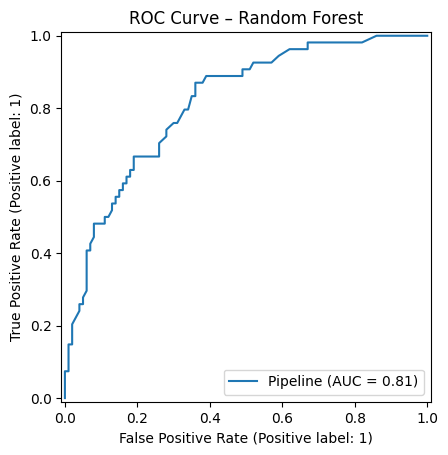

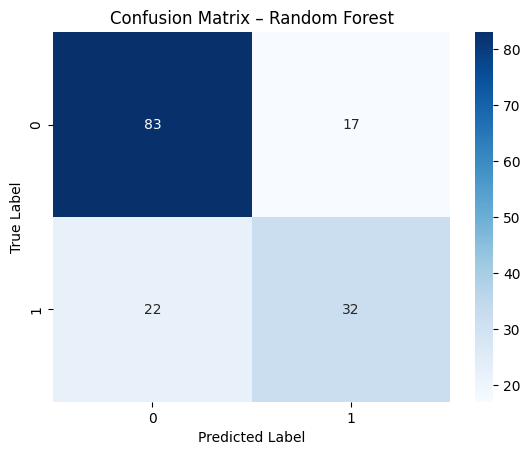

In [13]:
# Plotting ROC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve – Random Forest")
plt.show()

# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [14]:
# Checking where the model made mistakes
errors = X_test.copy()
errors["True"] = y_test.values
errors["Predicted"] = y_pred_rf
errors["Correct"] = errors["True"] == errors["Predicted"]

print("Total misclassified samples:", (~errors["Correct"]).sum())

# Looking for any visible pattern in wrong predictions
print("\nMean values for correctly vs incorrectly predicted cases:")
errors.groupby("Correct").mean().T


Total misclassified samples: 39

Mean values for correctly vs incorrectly predicted cases:


Correct,False,True
Pregnancies,4.692308,3.695652
Glucose,135.307692,115.930435
BloodPressure,71.256410,66.573913
SkinThickness,19.769231,19.513043
Insulin,90.256410,82.304348
BMI,33.648718,31.533913
DiabetesPedigreeFunction,0.373256,0.475678
Age,34.128205,32.269565
True,0.564103,0.278261
Predicted,0.435897,0.278261


In [15]:
# Saving the trained Random Forest model
joblib.dump(best_model, "diabetes_rf_model.joblib")
print("Model saved as 'diabetes_rf_model.joblib'")


Model saved as 'diabetes_rf_model.joblib'


In [16]:

#Final Notes:
#- Logistic Regression gave a simple, interpretable baseline.
#- Random Forest performed better and captured more complex relationships.
#- The model could be improved by trying XGBoost or adding more features.
#- The F1-score is important here because both false negatives and false positives matter.

In [17]:
joblib.dump(best_model, "diabetes_rf_model.joblib")


['diabetes_rf_model.joblib']

In [18]:
import joblib

# Load the saved model
model = joblib.load("diabetes_rf_model.joblib")

# Confirm it’s loaded
print("Model loaded successfully:", type(model))


Model loaded successfully: <class 'sklearn.pipeline.Pipeline'>


In [21]:
# Enter custom values manually
sample = [[6,148,72,35,0,33.6,0.627,50]]
pred = best_model.predict(sample)[0]

if pred == 1:
    print("✅ Person is likely Diabetic")
else:
    print("🩺 Person is likely Not Diabetic")


✅ Person is likely Diabetic


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [22]:
from sklearn.metrics import f1_score

y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


F1 Score: 0.6213592233009708


In [23]:
# Checking if data is imbalanced to increase the F1 score
df['Outcome'].value_counts()


,count
Outcome,
0,500
1,268


In [24]:
#it is imbalance
# Balancing the data using SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("Before SMOTE:", y.value_counts())
print("After SMOTE:", y_res.value_counts())


Before SMOTE: Outcome
0    500
1    268
Name: count, dtype: int64
After SMOTE: Outcome
1    500
0    500
Name: count, dtype: int64


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [26]:
from sklearn.metrics import f1_score, classification_report

y_pred = best_model.predict(X_test)
print("New F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


New F1 Score: 0.9035532994923858
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        99
           1       0.93      0.88      0.90       101

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



In [ ]:
#Now the F1 score is much better than previous.